In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_03.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_02.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_05.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_04.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_01.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/image.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_00.png
/kaggle/input/instance-seg-dataset/pseudo_masks/1_mp4-2_jpg.rf.a79f8eb621bf4ca2bef4cc2aa16f75e4/mask_06.png
/kaggle/input/instance-seg-dataset/pseudo_masks/4_mp4-3_jpg.rf.24133af9a76ae8e25d2271059cd57edd/mask_12.png
/kaggle/input/instance-seg-dat

In [2]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
from pycocotools import mask as mask_utils

img_root = "/kaggle/input/instance-seg-dataset/pseudo_masks"  # update this if needed
out_json = "/kaggle/working/vehicle_dataset.json"

image_id = 0
ann_id = 0
coco_dict = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "vehicle"}]
}

for folder in tqdm(sorted(os.listdir(img_root))):
    folder_path = os.path.join(img_root, folder)
    img_path = os.path.join(folder_path, "image.png")
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    coco_dict["images"].append({
        "id": image_id,
        "file_name": f"{folder}/image.png",
        "height": height,
        "width": width
    })

    for mask_file in sorted(os.listdir(folder_path)):
        if not mask_file.startswith("mask_"):
            continue
        mask = cv2.imread(os.path.join(folder_path, mask_file), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        bin_mask = (mask > 127).astype(np.uint8)
        if bin_mask.sum() == 0:
            continue

        encoded_mask = mask_utils.encode(np.asfortranarray(bin_mask))
        area = mask_utils.area(encoded_mask).item()
        bbox = mask_utils.toBbox(encoded_mask).tolist()
        
        coco_dict["annotations"].append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": 1,
            "segmentation": {
                "counts": encoded_mask["counts"].decode("utf-8"),
                "size": encoded_mask["size"]
            },
            "area": area,
            "bbox": bbox,
            "iscrowd": 0
        })

        ann_id += 1

    image_id += 1

# Save COCO JSON
with open(out_json, "w") as f:
    json.dump(coco_dict, f)


100%|██████████| 536/536 [01:15<00:00,  7.07it/s]


In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

# Dataset definition
class VehicleInstanceDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.img_folders = sorted(os.listdir(root_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.img_folders)

    def __getitem__(self, idx):
        folder = self.img_folders[idx]
        folder_path = os.path.join(self.root_dir, folder)
        img_path = os.path.join(folder_path, "image.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        masks = []
        for file in sorted(os.listdir(folder_path)):
            if file.startswith("mask_") and file.endswith(".png"):
                mask = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
                if mask is not None and mask.sum() > 0:
                    masks.append(mask > 127)

        valid_masks = []
        boxes = []
        for m in masks:
            if m.sum() == 0:
                continue
            pos = np.where(m)
            if pos[0].size == 0 or pos[1].size == 0:
                continue
            xmin, xmax = pos[1].min(), pos[1].max()
            ymin, ymax = pos[0].min(), pos[0].max()
            if xmax <= xmin or ymax <= ymin:
                continue
            boxes.append([xmin, ymin, xmax, ymax])
            valid_masks.append(m)

        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self))

        masks = np.stack(valid_masks).astype(np.uint8)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.ones((len(boxes),), dtype=torch.int64),
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([idx]),
            "area": (torch.tensor(boxes)[:, 3] - torch.tensor(boxes)[:, 1]) *
                    (torch.tensor(boxes)[:, 2] - torch.tensor(boxes)[:, 0]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Dataset & model setup
dataset_path = "/kaggle/input/instance-seg-dataset/pseudo_masks"
dataset = VehicleInstanceDataset(dataset_path, transforms=ToTensor())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.roi_heads.mask_predictor = MaskRCNNPredictor(256, 256, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 199MB/s] 


Epoch 1/10 - Loss: 217.8953
Epoch 2/10 - Loss: 159.6453
Epoch 3/10 - Loss: 142.2262
Epoch 4/10 - Loss: 132.1876
Epoch 5/10 - Loss: 121.3972
Epoch 6/10 - Loss: 113.1905
Epoch 7/10 - Loss: 106.8936
Epoch 8/10 - Loss: 100.7223
Epoch 9/10 - Loss: 92.9903
Epoch 10/10 - Loss: 89.6682


In [4]:
import torchvision
import torchvision.transforms as T

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(256, 256, 2)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def show_masked_predictions(model, dataset, device, num_images=3, score_thresh=0.5):
    model.to(device)  # ✅ Move model to the correct device
    model.eval()

    for _ in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        img, _ = dataset[idx]
        img_tensor = img.to(device).unsqueeze(0)

        with torch.no_grad():
            pred = model(img_tensor)[0]

        img_np = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        masks = pred["masks"]  # (N, 1, H, W)
        boxes = pred["boxes"]
        scores = pred["scores"]

        plt.figure(figsize=(12, 12))
        plt.imshow(img_np)
        ax = plt.gca()

        for i in range(len(scores)):
            if scores[i] < score_thresh:
                continue
            mask = masks[i, 0].mul(255).byte().cpu().numpy()
            color = np.random.rand(3)
            img_np[mask > 127] = img_np[mask > 127] * 0.5 + np.array(color) * 255 * 0.5
            x1, y1, x2, y2 = boxes[i].int().tolist()
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

        plt.axis('off')
        plt.imshow(img_np)
        plt.show()


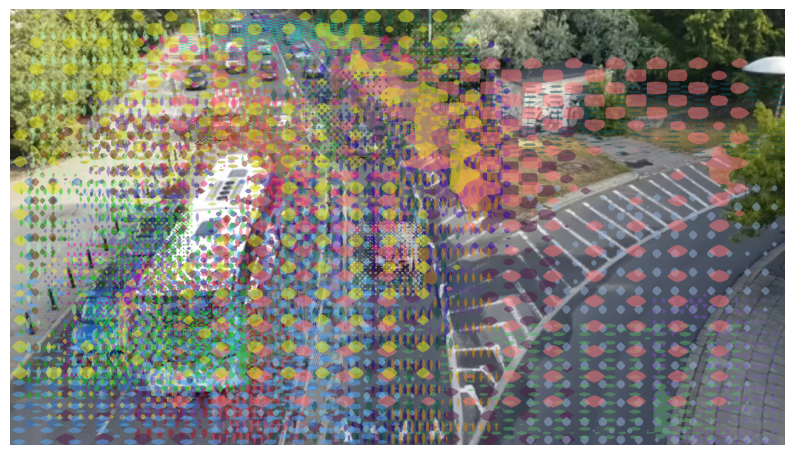

In [6]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def run_inference_on_image(model, image_path, device, score_thresh=0.5):
    # Load and preprocess image
    model.to(device)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img / 255.).permute(2, 0, 1).float().to(device).unsqueeze(0)

    # Run inference
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0]

    # Extract predictions
    masks = pred["masks"]  # (N, 1, H, W)
    boxes = pred["boxes"]
    scores = pred["scores"]

    # Visualize
    img_out = img.copy()
    for i in range(len(scores)):
        if scores[i] < score_thresh:
            continue
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        color = np.random.rand(3)
        img_out[mask > 127] = img_out[mask > 127] * 0.5 + np.array(color) * 255 * 0.5
        # x1, y1, x2, y2 = boxes[i].int().tolist()
        # cv2.rectangle(img_out, (x1, y1), (x2, y2), color * 255, 2)

    # Show output
    plt.figure(figsize=(10, 10))
    plt.imshow(img_out.astype(np.uint8))
    plt.axis("off")
    plt.show()

# Example usage
run_inference_on_image(model, "/kaggle/input/test-img/frame1.jpg", device)
